# Protein Synthesis Simulation

Load dataset:

In [1]:
from HumanGenomeDataset.load_dataset import load_dataset

data_df = load_dataset('dna_protein_coding_sequences')
data_df.head(2)

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,ID,sequence,category
0,NM_001368254.1,GCTGAGCTGAGCTGGGGCGCAGCCGCCTGTCTGCACCGGCAGCACC...,NM
1,NM_001350977.1,TCCACAACTGAAACATCCACTTCTGAACACCATGTCCTACTACAGC...,NM


### Simulation

In [2]:
from src.simulation import ProteinSinthesisProcess

In [3]:
SIM_TIME = 3600*2 # 2 hours
NUMBER_RESOURCES = 5
NUMBER_RNA_POLYMERASES = 3
NUMBER_RIBOSOMES = 2
URACIL_INITIAL_AMOUNT = 50000
ADENINE_INITIAL_AMOUNT = 50000
GUANINE_INITIAL_AMOUNT = 50000
CYTOSINE_INITIAL_AMOUNT = 50000
RANDOM_SEED = 42

protein_synthesis_process = ProteinSinthesisProcess(
    dna_sequences_df=data_df,
    number_resources=NUMBER_RESOURCES,
    number_rna_polymerases=NUMBER_RNA_POLYMERASES, 
    number_ribosomes=NUMBER_RIBOSOMES,
    uracil_initial_amount=URACIL_INITIAL_AMOUNT,
    adenine_initial_amount=ADENINE_INITIAL_AMOUNT,
    guanine_initial_amount=GUANINE_INITIAL_AMOUNT,
    cytosine_initial_amount=CYTOSINE_INITIAL_AMOUNT,
    random_seed=RANDOM_SEED,
    verbose=True
    )

Simulation environment initialized, time unit: 0.0001 second.


In [4]:
print(protein_synthesis_process)

Protein Sinthesis Process:
185310 dna sequences to synthesize,
5 resources available,
3 RNA polymerases,
2 ribosomes,
50000 uracil bases,
50000 adenine bases,
50000 guanine bases,
50000 cytosine bases.


Start simulation:

In [5]:
protein_synthesis_process.run(simulation_time=SIM_TIME) # run the simulation

Simulation started
Time 0.0000: DNA Sequence 0 requesting to start synthesis
Time 0.0000: DNA Sequence 0 synthesize started
Time 0.0000: DNA Sequence 0 start transcription process
Time 0.0000: DNA Sequence 0 contains 6 promoters
Time 0.0000: DNA Sequence 0 (mRNA sequence 0) start transcription process
Time 11.1331: DNA Sequence 1 requesting to start synthesis
Time 11.1331: DNA Sequence 1 synthesize started
Time 11.1331: DNA Sequence 1 start transcription process
Time 11.1331: DNA Sequence 1 contains 1 promoters
Time 11.1331: DNA Sequence 1 (mRNA sequence 0) start transcription process
Time 66.9531: DNA Sequence 1 start translation process
Time 66.9531: DNA Sequence 1 (mRNA sequence 0) start translation process
Time 69.3531: DNA Sequence 1 (mRNA sequence 0) end translation process
Time 69.3531: DNA Sequence 1 end transcription and translation process
Time 69.3531: DNA Sequence 1 synthetis ended
Time 105.6081: DNA Sequence 2 requesting to start synthesis
Time 105.6081: DNA Sequence 2 syn

In [6]:
protein_synthesis_process.save_process() # save the process

Process saved.


### Results

In [7]:
import pandas as pd
results_path = 'results/results.csv'

results_df = pd.read_csv(results_path, index_col=0)

In [8]:
print('Number of DNA sequence traslated:', results_df[results_df['mrna_sequences'].notna()].shape[0])
print('Number of DNA sequence not traslated:', results_df[results_df['protein_synthesized']==False].shape[0])

Number of DNA sequence traslated: 41
Number of DNA sequence not traslated: 3


In [9]:
results_df.columns

Index(['ID', 'category', 'end_process_time', 'end_translation_time',
       'length_proteins', 'mrna_sequences', 'number_different_proteins',
       'number_of_proteins_synthesized', 'polypeptides_chains',
       'polypeptides_chains_ext', 'protein_synthesized',
       'request_start_process_time', 'sequence', 'start_process_time',
       'start_transcription_time', 'start_translation_time'],
      dtype='object')

In [10]:
results_df[results_df['mrna_sequences'].notna()][[
    'polypeptides_chains', 'number_of_proteins_synthesized', 'length_proteins', 'number_different_proteins']]

,polypeptides_chains,number_of_proteins_synthesized,length_proteins,number_different_proteins
2767,"['NH2-LYRFRFYFLFVEG-COOH', 'NH2-LYRFRFYFLFVEG-...",4,"[13, 13, 13, 13]",1.0
7553,"['NH2-RAKLRF-COOH', 'NH2-RAKLRF-COOH', 'NH2-RA...",4,"[6, 6, 6, 6]",1.0
11727,['NH2-GRTAASGARADGGAGAGTFGGSGAQSSDRGGGCQSSATGA...,3,"[53, 53, 53]",1.0
11903,"['NH2-RPTRGSGRRRRYSHDPLY-COOH', 'NH2-RPTProGSG...",3,"[18, 20, 20]",2.0
16622,"['NH2-SILHSNSQIRKFRPEE-COOH', 'NH2-SILHSNSQIRK...",2,"[16, 16]",1.0
26186,['NH2-KCMSRELLLYLALFLVGRKRGNMKGYLDVAFLRDWFLYLI...,1,[62],1.0
31996,"[None, None, None]",3,[],0.0
39859,['NH2-PSQGPRHPSSSPSAAWQGAPRATTSTPSTRSTTCFGGYNN...,5,"[41, 41, 41, 41, 41]",2.0
47163,['NH2-R-COOH'],1,[1],1.0
48738,"['NH2-WEVKEPISGVHSHR-COOH', 'NH2-WEVKEPISGVHSH...",3,"[14, 14, 14]",2.0


Plot results

In [11]:
from src.utils.plot_utils import *

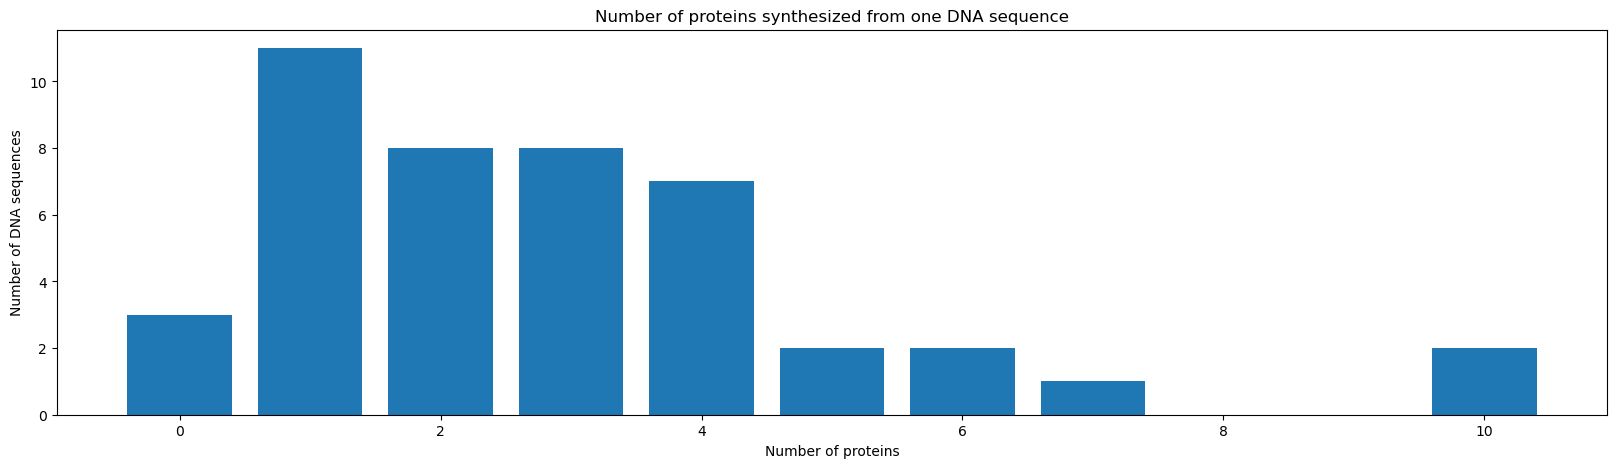

In [12]:
barplot_proteins_number(results_df)

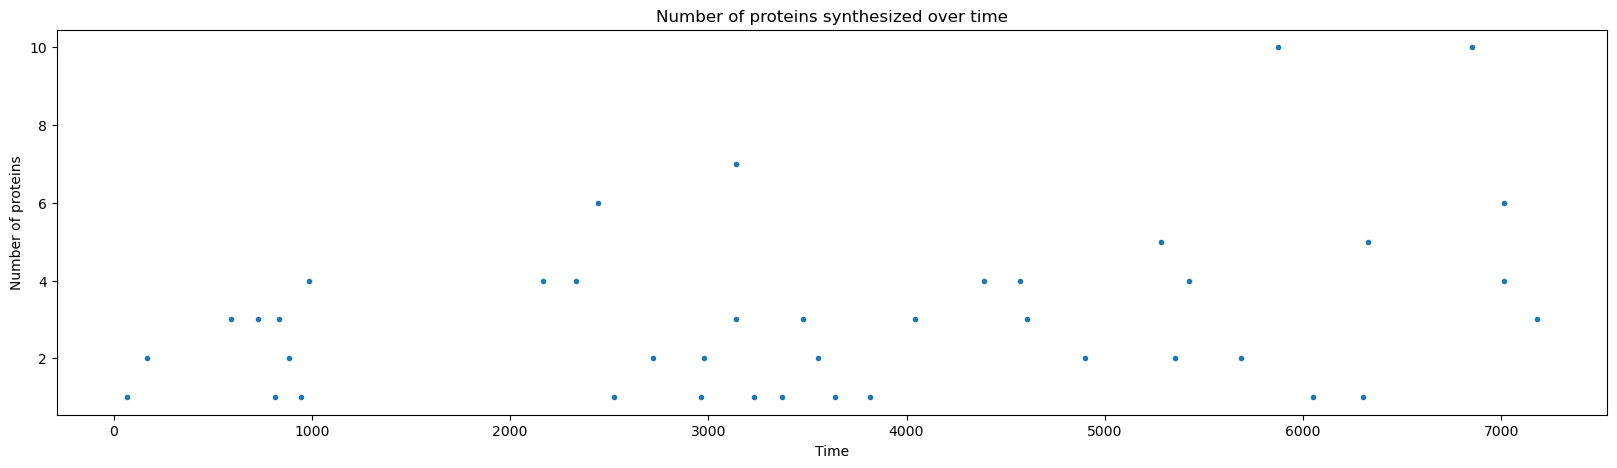

In [13]:
plot_proteins_number_over_time(results_df)

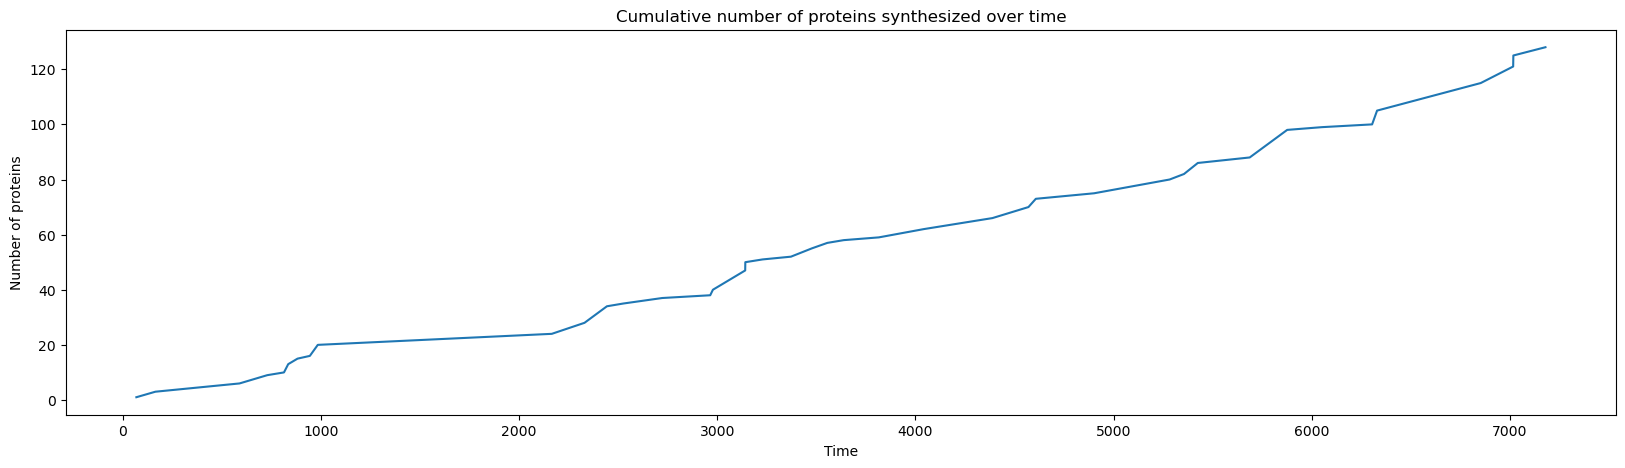

In [14]:
plot_cumulative_proteins_number_over_time(results_df)

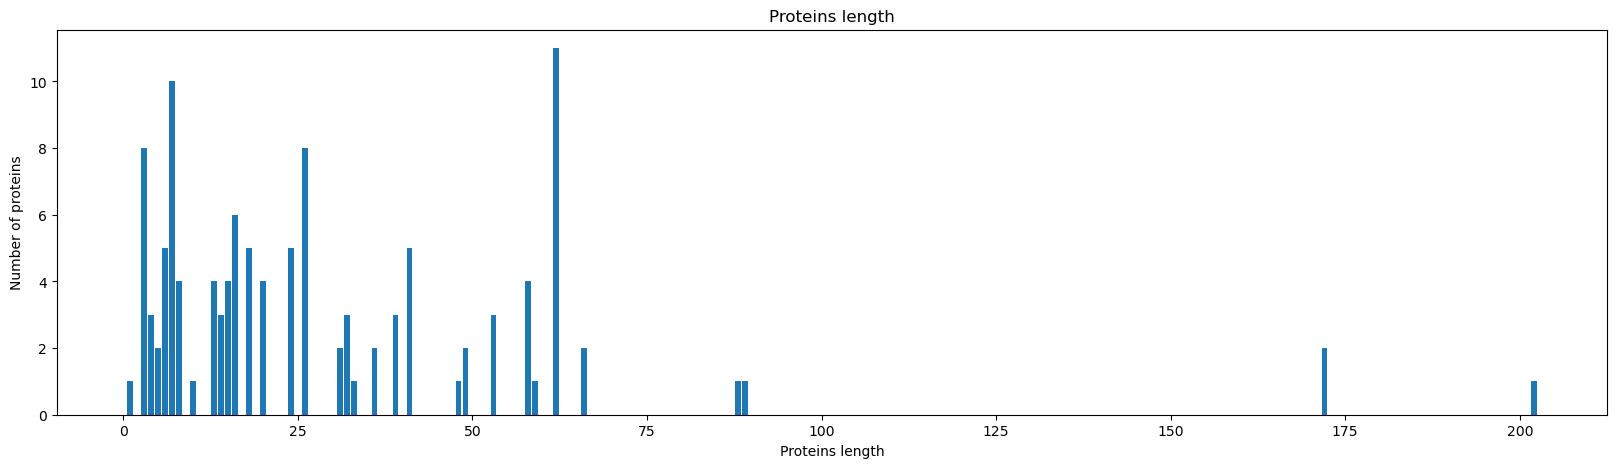

In [15]:
barplot_proteins_length(results_df)